# 7. Decision Trees

The purpose of this notebook is to generate decision trees for the climate related headlines and the introduced climate bills. This will inform what is semantically meaningful to assigning something to a particular label.

## 1. Environment Creation

### 1.1 Library Import

In [78]:
''' DATA MANAGEMENT ''' 
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import ast
from collections import Counter
import regex as re
import numpy as np

''' VECTORIZATION '''
from sklearn.feature_extraction.text import CountVectorizer


''' DATA VISUALIZATION '''
import seaborn as sb
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import graphviz
from mpl_toolkits.mplot3d import Axes3D 
from mpl_toolkits.mplot3d import Axes3D 
from IPython.display import Image
import pydotplus
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from tabulate import tabulate

''' SANITY '''
from tqdm import tqdm

''' DECIISION TREE '''
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

''' MODEL VERIFICATION  '''
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


### 1.2 Function Definition

In [3]:
def train_test_splitter(data, label_column):
    
    data_train, data_test = train_test_split(data, test_size = 0.3,)
    labels_train = data_train[label_column]
    labels_test = data_test[label_column]
    
    #data_train.drop(columns='LABEL', inplace=True)
    #data_test.drop(columns='LABEL', inplace=True)
    
    
    return (data_train, data_test, labels_train, labels_test)

In [4]:

def visual_confusion_matrix(data,labels, predictions ,title, label_name, file_name, fig_x, fig_y):
    
    _labels = sorted(set(labels).union(set(predictions)))

    confusion_df = pd.DataFrame(data, index=_labels, columns=_labels)

    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
        
    
    sb.heatmap(confusion_df, annot = True, fmt='d', xticklabels=_labels, yticklabels=_labels, cbar_kws={'shrink': 0.5}, ax=ax)
    ax.set_title(f"Confusion Matrix:\n{title}\nLabels: {label_name}")
    ax.set_ylabel("True Labels")
    ax.set_xlabel("Predicted Labels")
    
    ax.set_aspect('equal', adjustable='box')
    #plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)
    
    # Save and show the plot
    
    plt.tight_layout(pad=.5)
    plt.savefig(file_name, dpi=600)
    
    plt.show()

In [5]:
def model_verification(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division = 0)
    recall = recall_score(true_labels, predictions, average='macro', zero_division = 0)
    
    return accuracy, precision, recall

In [6]:
def filter_top_n_labels(labels, predictions, N):
    top_labels = [label for label, _ in Counter(labels).most_common(N)]
    mask = [(yt in top_labels and yp in top_labels) for yt, yp in zip(labels, predictions)]
    labels_filtered = [yt for yt, m in zip(labels, mask) if m]
    predictions_filtered = [yp for yp, m in zip(predictions, mask) if m]
    return labels_filtered, predictions_filtered


In [98]:
## Decision Tree Modeler:
def tree_modeler(data_train, labels_train, data_test, labels_test, label_column_name, feature_names, graph_title, labels_name, file_name,filter_top_n = False, N=10 ,fig_x = 6, fig_y = 4):
    data_train = data_train.drop(columns = label_column_name).copy()
    data_test = data_test.drop(columns = label_column_name).copy()
    
    feature_names_train = list(data_train.columns)
    feature_names_test = list(data_test.columns)
    
    decision_tree = DecisionTreeClassifier(criterion='entropy', ## This is changed based on the model test that was used
                                      splitter = 'best',
                                      max_depth = 8,
                                      min_samples_split = 4,
                                      min_samples_leaf = 1,
                                      min_weight_fraction_leaf = 0,
                                      max_features = 500,
                                      random_state = 30,
                                      max_leaf_nodes = None,
                                      min_impurity_decrease = 0.0,
                                      class_weight = 'balanced')

    ## Fitting the data
    decision_tree_model = decision_tree.fit(data_train, labels_train)
    
    ## Plotting the tree
    dot_data = tree.export_graphviz(decision_tree_model, out_file=None,
                                    feature_names=feature_names_train,
                                    filled=True,
                                    rounded=True,
                                    special_characters=True,)
    
    graph = graphviz.Source(dot_data)
    graph.render(f"Decision Tree - {graph_title}")
    
    
    ## Creating predictions
    predictions = decision_tree_model.predict(data_test)
    
    

    ## Assessing the models abilitiy
    accuracy, precision, recall = model_verification(labels_test, predictions)
    
    ## Filtering for Clean Visualizations
    if filter_top_n == True:
        labels_test, predictions = filter_top_n_labels(labels_test, predictions, N)

    ## Generating a confusion matrix
    
    matrix_ = confusion_matrix(labels_test, predictions)
    visual_confusion_matrix(matrix_, labels_test, predictions, graph_title, labels_name, file_name, fig_x, fig_y)
    
    return (accuracy, precision, recall)

### 1.3 Data Import

In [8]:
news_data = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\News Articles Lemmed- Count Vectorizer.csv")
news_data.fillna(0,inplace=True)
news_data.drop(columns='Unnamed: 0', inplace = True)

non_zero_condition = news_data['Party'] != 0
news_data = news_data[non_zero_condition]

In [9]:
bills_data = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\Bills Lemmed- Count Vectorizer.csv")
bills_data.fillna(0,inplace=True)
bills_data.drop(columns='Unnamed: 0', inplace = True)

non_zero_condition = bills_data['Committees'] != 0
bills_data = bills_data[non_zero_condition]

In [10]:
party_data = pd.read_csv(r"C:\Users\natal\OneDrive\university\info 5653\data\Party Platform Lemmed- Count Vectorizer.csv")
party_data.drop(columns='Unnamed: 0', inplace = True)

In [11]:
''' REVECTORIZING DATA '''

## Recreate CountVectorizer with the original vocabulary
vectorizer_news = CountVectorizer(vocabulary=news_data.columns)
vectorizer_bills = CountVectorizer(vocabulary=bills_data.columns)
vectorizer_party = CountVectorizer(vocabulary=party_data.columns)


In [31]:
''' PULLING OUT THE FEATURE NAMES '''
features_news = news_data.columns.to_list()
features_bills = bills_data.columns.to_list()
features_party = party_data.columns.to_list()

## Removing the labels
features_news = features_news[2:]
features_bills = features_bills[4:]
features_party = features_party[1:]

In [13]:
''' CREATING A COMBINED LABEL COLUMN FOR MORE LABEL INFORMATINO IN SKLEARN '''

news_data.insert(0, 'LABEL', news_data['Party'].astype(str).fillna('') + ' | ' + news_data['publisher'].astype(str).fillna(''))

## note: the committee was not added to this because of the diversity and length  of the committee
## - so the purpose of this column is more in order to generate a nunance about sponser state, affiliation,
## and bill type
bills_data.insert(0, 'LABEL', bills_data['Bill Type'].astype(str).fillna('') + ' | ' + bills_data['Sponser Affiliation'].astype(str).fillna('') +' | ' + bills_data['Sponser State'].astype(str).fillna(''))

In [14]:
''' STORING THE LABELS '''

## News Data
labels_news_party = news_data['Party'].to_list()
labels_news_publisher = news_data['publisher'].to_list()
labels_news_combined = news_data['LABEL'].to_list()

## Bill Data
labels_bills_billtype = bills_data['Bill Type']
labels_bills_sponser_affiliation = bills_data['Sponser Affiliation']
labels_bills_sponser_state = bills_data['Sponser State']
labels_bills_committees = bills_data['Committees']
labels_bills_combined = bills_data['LABEL'].to_list()

## Party Platform Data
labels_party_party = party_data['Party']

In [15]:
news_data.head(2)

,LABEL,Party,publisher,aapi,abandon,abandoned,abc,ability,able,abolish,...,yes,york,young,youth,zealot,zeldin,zero,zers,zone,zuckerberg
0,Republican | The Verge,Republican,The Verge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Republican | Gizmodo.com,Republican,Gizmodo.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
bills_data.head(2)

,LABEL,Bill Type,Sponser Affiliation,Sponser State,Committees,aa,aaa,aarhu,ab,abandon,...,zoe,zone,zonea,zonesnotwithstand,zoneth,zoo,zoolog,zoonot,zooplankton,zquez
0,hr | D | HI,hr,D,HI,"House - Natural Resources, Agriculture | Senat...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hr | R | NY,hr,R,NY,House - Agriculture,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
party_data.head()

,Party,ability,able,abortion,access,accessible,according,accountability,accountable,achieved,...,won,word,work,worker,working,world,worship,worst,year,young
0,Republican,1,1,1,4,1,1,1,4,1,...,1,1,4,15,2,15,2,1,7,7
1,Democrat,7,13,13,72,15,1,6,14,1,...,10,1,101,79,81,69,4,4,149,10


## 2. Data Preparation

### 2.1 Generating a Train Test Split for the Data

#### 2.1.1 News Data

In [46]:
## Creating individually labeled sets for the data

news_data_label_party = news_data.drop(columns = ['publisher', 'LABEL'])
data_train_news_party, data_test_news_party, labels_train_news_party, labels_test_news_party = train_test_splitter(news_data_label_party,'Party')

news_data_label_publisher = news_data.drop(columns = ['Party', 'LABEL'])
data_train_news_publisher, data_test_news_publisher, labels_train_news_publisher, labels_test_news_publisher = train_test_splitter(news_data_label_publisher,'publisher')

news_data_label_combined = news_data.drop(columns = ['Party', 'publisher'])
data_train_news_combined, data_test_news_combined, labels_train_news_combined, labels_test_news_combined = train_test_splitter(news_data_label_combined,'LABEL')


In [18]:
bills_data_label_party = bills_data.drop(columns = ['LABEL', 'Bill Type', 'Sponser State', 'Committees'])
data_train_bills_party, data_test_bills_party, labels_train_bills_party, labels_test_bills_party = train_test_splitter(bills_data_label_party,'Sponser Affiliation')


bills_data_label_state = bills_data.drop(columns = ['LABEL', 'Bill Type', 'Sponser Affiliation', 'Committees'])
data_train_bills_state, data_test_bills_state, labels_train_bills_state, labels_test_bills_state = train_test_splitter(bills_data_label_state,'Sponser State')


bills_data_label_combined = bills_data.drop(columns = ['Sponser State', 'Bill Type', 'Sponser Affiliation', 'Committees'])
data_train_bills_combined, data_test_bills_combined, labels_train_bills_combined, labels_test_bills_combined = train_test_splitter(bills_data_label_combined,'LABEL')

bills_data_label_type = bills_data.drop(columns = ['LABEL', 'Sponser State', 'Sponser Affiliation', 'Committees'])
data_train_bills_type, data_test_bills_type, labels_train_bills_type, labels_test_bills_type = train_test_splitter(bills_data_label_type,'Bill Type')

bills_data_label_committee = bills_data.drop(columns = ['LABEL', 'Bill Type', 'Sponser Affiliation', 'Sponser State'])
data_train_bills_committee, data_test_bills_committee, labels_train_bills_committee, labels_test_bills_committee = train_test_splitter(bills_data_label_committee,'Committees')



In [19]:
length_data = [['News Headline: Partisian Affiliation',len(data_train_news_party), len(data_test_news_party)],
['News Headlines: Publisher',len(data_train_news_publisher), len(data_test_news_publisher)], 
['News Headlines: Publisher and Partisian Affiliation',len(data_train_news_combined), len(data_test_news_combined)], 
['Climate Bills: Sponsor Affiliation',len(data_train_bills_party), len(data_test_bills_party)], 
['Climate Bills: Sponsor State',len(data_train_bills_state), len(data_test_bills_state)], 
['Climate Bills: Metadata',len(data_train_bills_combined), len(data_test_bills_combined)], 
['Climate Bills: Bill Type',len(data_train_bills_type), len(data_test_bills_type)], 
['Climate Bills: Hearing Committee',len(data_train_bills_committee), len(data_test_bills_committee)]]

headers = ['', ' Training Data', 'Testing Data']

length_table = tabulate(length_data, headers=headers, tablefmt='html', numalign='center', stralign = 'left')

with open("Decision Tree - Train Test Split Lengths.html", "w") as file:
    file.write(length_table)
    
length_table

,Training Data,Testing Data
News Headline: Partisian Affiliation,573,246
News Headlines: Publisher,573,246
News Headlines: Publisher and Partisian Affiliation,573,246
Climate Bills: Sponsor Affiliation,2256,967
Climate Bills: Sponsor State,2256,967
Climate Bills: Metadata,2256,967
Climate Bills: Bill Type,2256,967
Climate Bills: Hearing Committee,2256,967


## 3. Training the Decision Tree Model

```python
def tree_modeler(data_train, labels_train, data_test, labels_test, label_column_name, feature_names, graph_title, labels_name, file_name,filter_top_n = False, N=10 ,fig_x = 6, fig_y = 4):
```

### 3.1 News Headlines

#### 3.1.1 Gini

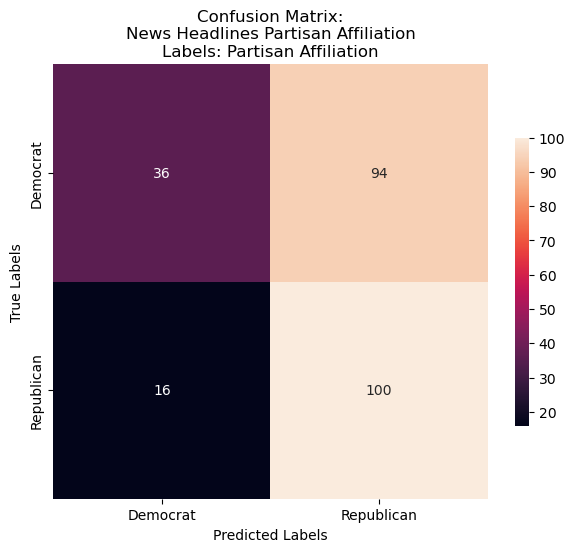

In [61]:
accuracy_news_data_party, precision_news_data_party, recall_news_data_party = tree_modeler(data_train_news_party, labels_train_news_party,
                                                                                         data_test_news_party, labels_test_news_party,
                                                                                          'Party',
                                                                                         'News Headlines',
                                                                                         'News Headlines Partisan Affiliation', 'Partisan Affiliation', 'decision tree gini cm- news partisian affiliation.png',
                                                                                         False, 10,fig_x = 6, fig_y = 6)

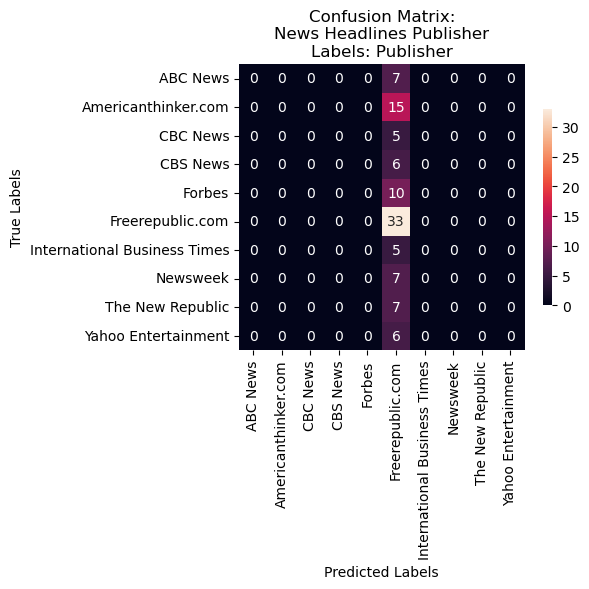

In [62]:
accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher = tree_modeler(data_train_news_publisher, labels_train_news_publisher,
                                                                                         data_test_news_publisher, labels_test_news_publisher,
                                                                                          'publisher',
                                                                                         'News Headlines Publisher',
                                                                                         'News Headlines Publisher', 'Publisher', 'decision tree gini cm - news publisher.png',
                                                                                         True, 10,fig_x = 6, fig_y = 6)

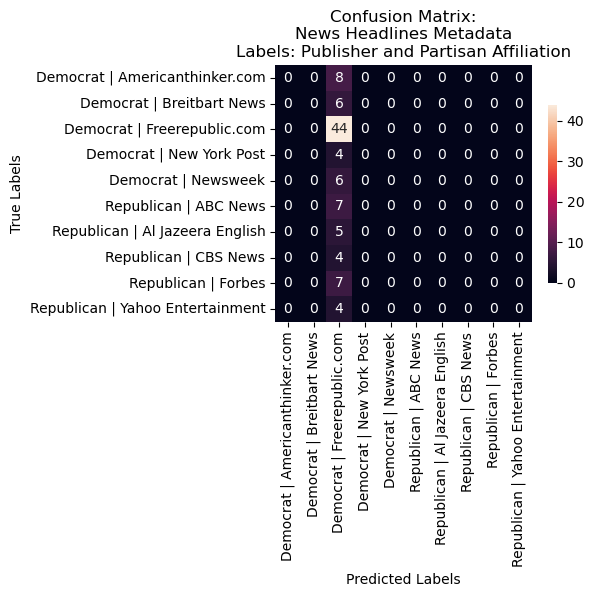

In [63]:
accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined = tree_modeler(data_train_news_combined, labels_train_news_combined,
                                                                                         data_test_news_combined, labels_test_news_combined,
                                                                                          'LABEL',
                                                                                         'News Headlines Metadata',
                                                                                         'News Headlines Metadata', 'Publisher and Partisan Affiliation', 'decision tree gini cm - news metadata.png',
                                                                                         True, 10,fig_x = 6, fig_y = 6)

#### 3.2.2 Entropy

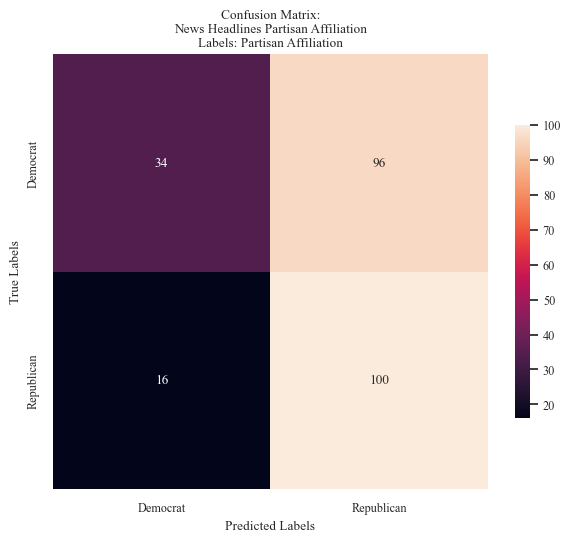

In [85]:
accuracy_news_data_party, precision_news_data_party, recall_news_data_party = tree_modeler(data_train_news_party, labels_train_news_party,
                                                                                         data_test_news_party, labels_test_news_party,
                                                                                          'Party',
                                                                                         'News Headlines',
                                                                                         'News Headlines Partisan Affiliation', 'Partisan Affiliation', 'decision tree entropy cm- news partisian affiliation.png',
                                                                                         False, 10,fig_x = 6, fig_y = 6)

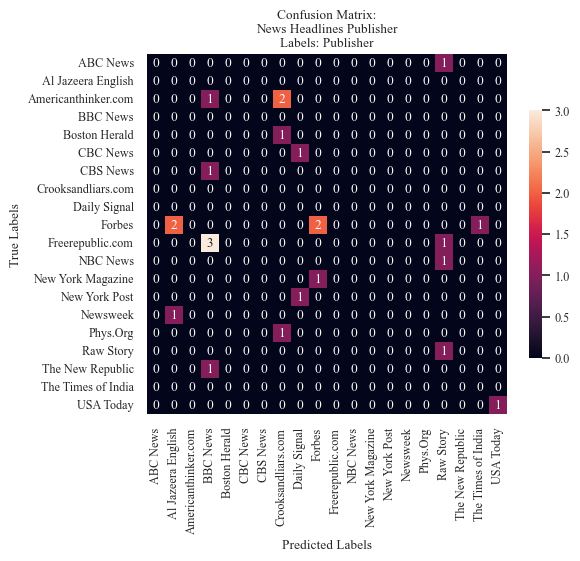

In [103]:
accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher = tree_modeler(data_train_news_publisher, labels_train_news_publisher,
                                                                                         data_test_news_publisher, labels_test_news_publisher,
                                                                                          'publisher',
                                                                                         'News Headlines Publisher',
                                                                                         'News Headlines Publisher', 'Publisher', 'decision tree entropy cm - news publisher.png',
                                                                                         True, 30,fig_x = 6, fig_y = 6)

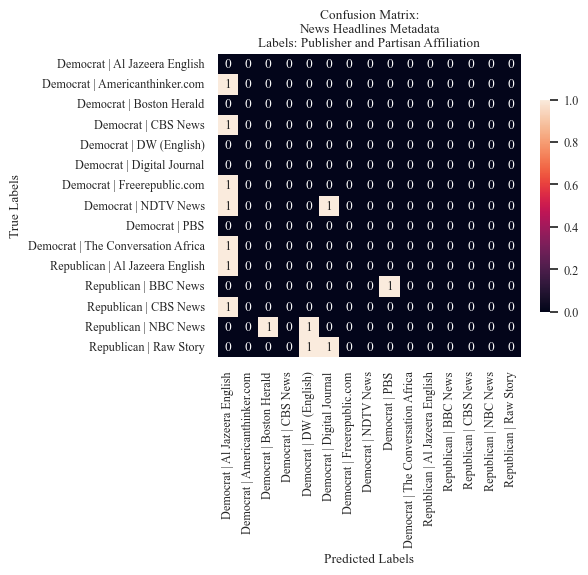

In [104]:
accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined = tree_modeler(data_train_news_combined, labels_train_news_combined,
                                                                                         data_test_news_combined, labels_test_news_combined,
                                                                                          'LABEL',
                                                                                         'News Headlines Metadata',
                                                                                         'News Headlines Metadata', 'Publisher and Partisan Affiliation', 'decision tree entropy cm - news metadata.png',
                                                                                         True, 30,fig_x = 6, fig_y = 6)

### 3.2 Climate Bills Data

#### 3.2.1 Gini

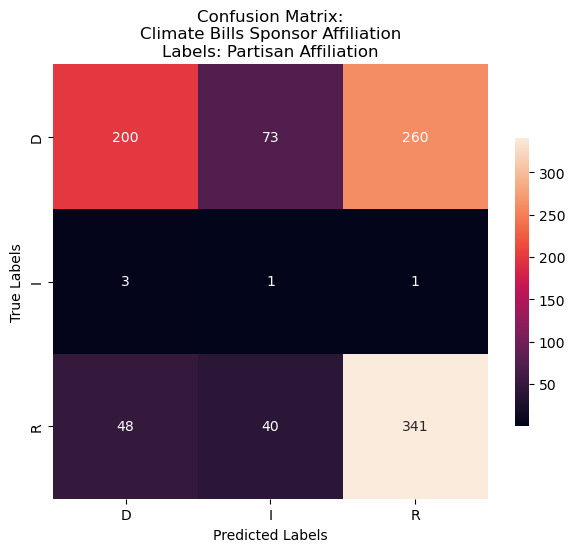

In [64]:
accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party = tree_modeler(data_train_bills_party, labels_train_bills_party,
                                                                                         data_test_bills_party, labels_test_bills_party,
                                                                                          'Sponser Affiliation',
                                                                                         'Climate Bills Sponsor Affiliation',
                                                                                         'Climate Bills Sponsor Affiliation', 'Partisan Affiliation', 'decision tree gini cm- bills partisian affiliation.png',
                                                                                         False, 10,fig_x = 6, fig_y = 6)

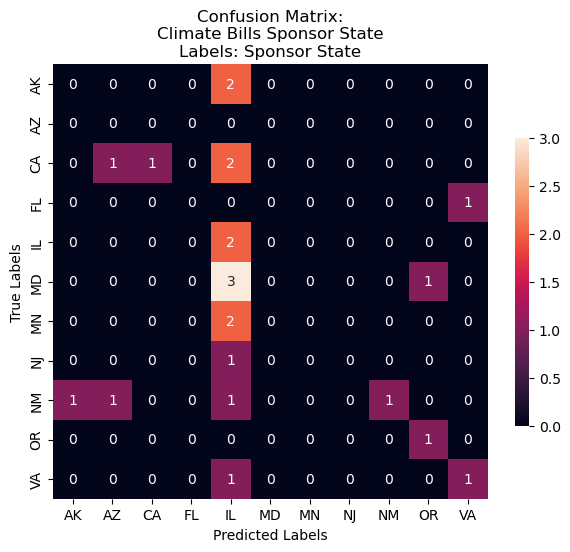

In [67]:
accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state = tree_modeler(data_train_bills_state, labels_train_bills_state,
                                                                                         data_test_bills_state, labels_test_bills_state,
                                                                                          'Sponser State',
                                                                                         'Climate Bills Sponsor State',
                                                                                         'Climate Bills Sponsor State', 'Sponsor State', 'decision tree gini cm- bills sponsor state.png',
                                                                                         True, 20 ,fig_x = 6, fig_y = 6)

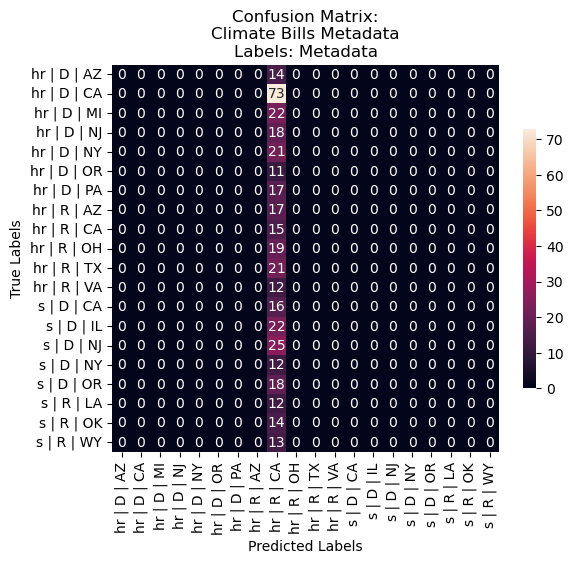

In [68]:
accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined = tree_modeler(data_train_bills_combined, labels_train_bills_combined,
                                                                                         data_test_bills_combined, labels_test_bills_combined,
                                                                                          'LABEL',
                                                                                         'Climate Bills Metadata',
                                                                                         'Climate Bills Metadata', 'Metadata', 'decision tree gini cm- bills combined label.png',
                                                                                         True, 20 ,fig_x = 6, fig_y = 6)

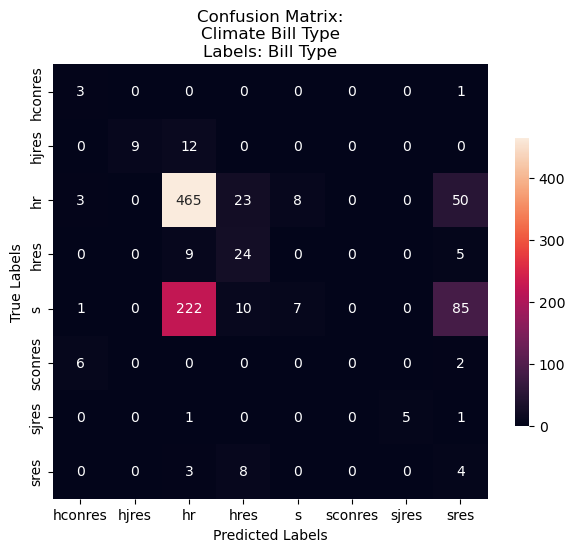

In [69]:
accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type = tree_modeler(data_train_bills_type, labels_train_bills_type,
                                                                                         data_test_bills_type, labels_test_bills_type,
                                                                                          'Bill Type',
                                                                                         'Climate Bill Type',
                                                                                         'Climate Bill Type', 'Bill Type', 'decision tree gini cm- bill type label.png',
                                                                                         False, 20 ,fig_x = 6, fig_y = 6)

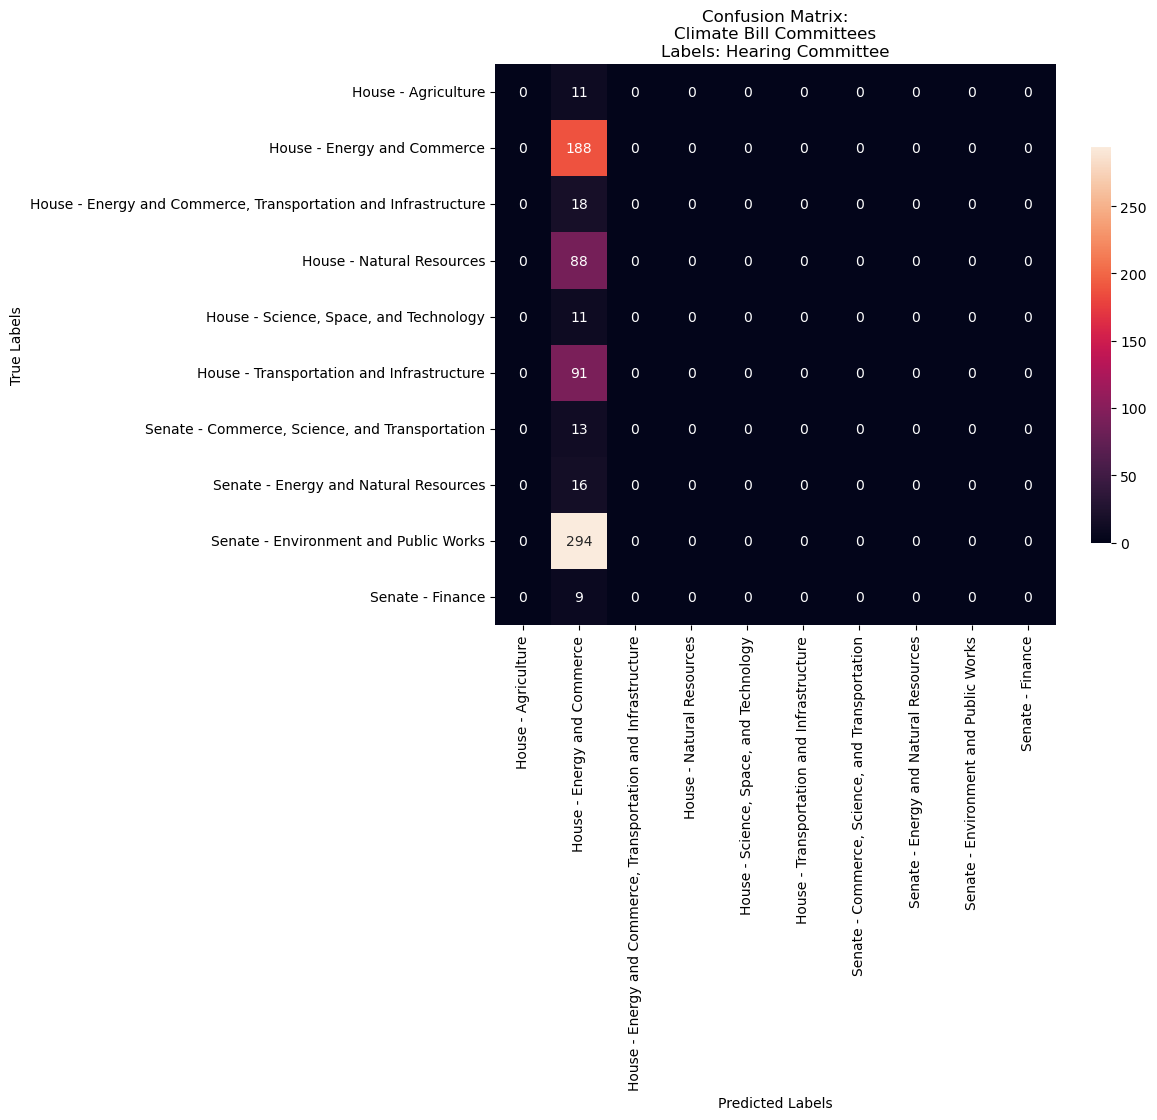

In [72]:
accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee = tree_modeler(data_train_bills_committee, labels_train_bills_committee,
                                                                                         data_test_bills_committee, labels_test_bills_committee,
                                                                                          'Committees',
                                                                                         'Climate Bill Committees',
                                                                                         'Climate Bill Committees', 'Hearing Committee', 'decision tree gini cm- bill committee label.png',
                                                                                         True, 10 ,fig_x = 12, fig_y = 12)

#### 3.2.2 Entropy

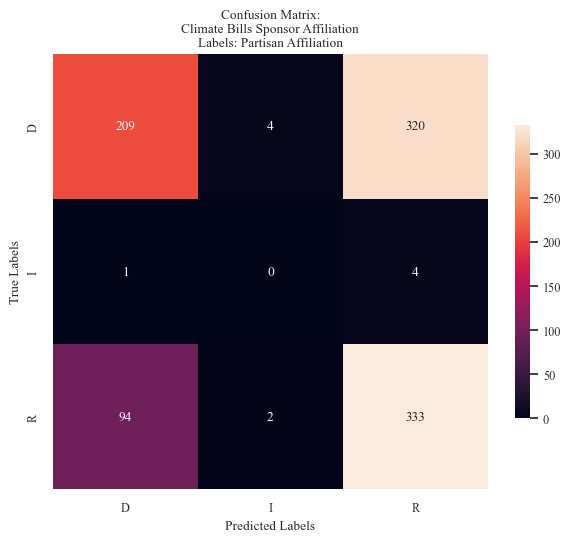

In [91]:
accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party = tree_modeler(data_train_bills_party, labels_train_bills_party,
                                                                                         data_test_bills_party, labels_test_bills_party,
                                                                                          'Sponser Affiliation',
                                                                                         'Climate Bills Sponsor Affiliation',
                                                                                         'Climate Bills Sponsor Affiliation', 'Partisan Affiliation', 'decision tree entropy cm- bills partisian affiliation.png',
                                                                                         False, 10,fig_x = 6, fig_y = 6)

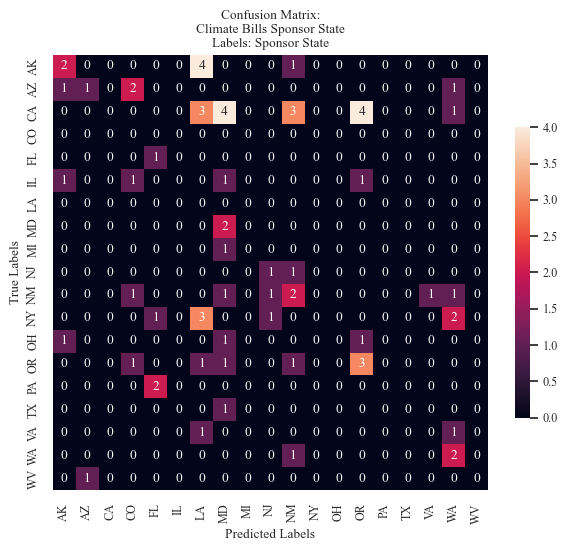

In [92]:
accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state = tree_modeler(data_train_bills_state, labels_train_bills_state,
                                                                                         data_test_bills_state, labels_test_bills_state,
                                                                                          'Sponser State',
                                                                                         'Climate Bills Sponsor State',
                                                                                         'Climate Bills Sponsor State', 'Sponsor State', 'decision tree entropy cm- bills sponsor state.png',
                                                                                         True, 20 ,fig_x = 6, fig_y = 6)

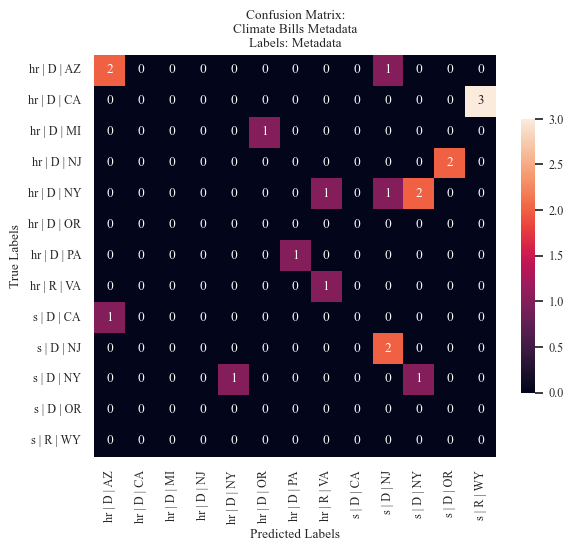

In [93]:
accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined = tree_modeler(data_train_bills_combined, labels_train_bills_combined,
                                                                                         data_test_bills_combined, labels_test_bills_combined,
                                                                                          'LABEL',
                                                                                         'Climate Bills Metadata',
                                                                                         'Climate Bills Metadata', 'Metadata', 'decision tree entropy cm- bills combined label.png',
                                                                                         True, 20 ,fig_x = 6, fig_y = 6)

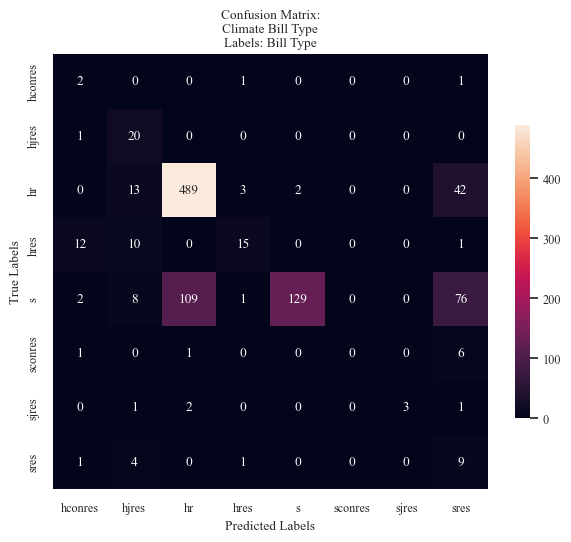

In [94]:
accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type = tree_modeler(data_train_bills_type, labels_train_bills_type,
                                                                                         data_test_bills_type, labels_test_bills_type,
                                                                                          'Bill Type',
                                                                                         'Climate Bill Type',
                                                                                         'Climate Bill Type', 'Bill Type', 'decision tree entropy cm- bill type label.png',
                                                                                         False, 20 ,fig_x = 6, fig_y = 6)

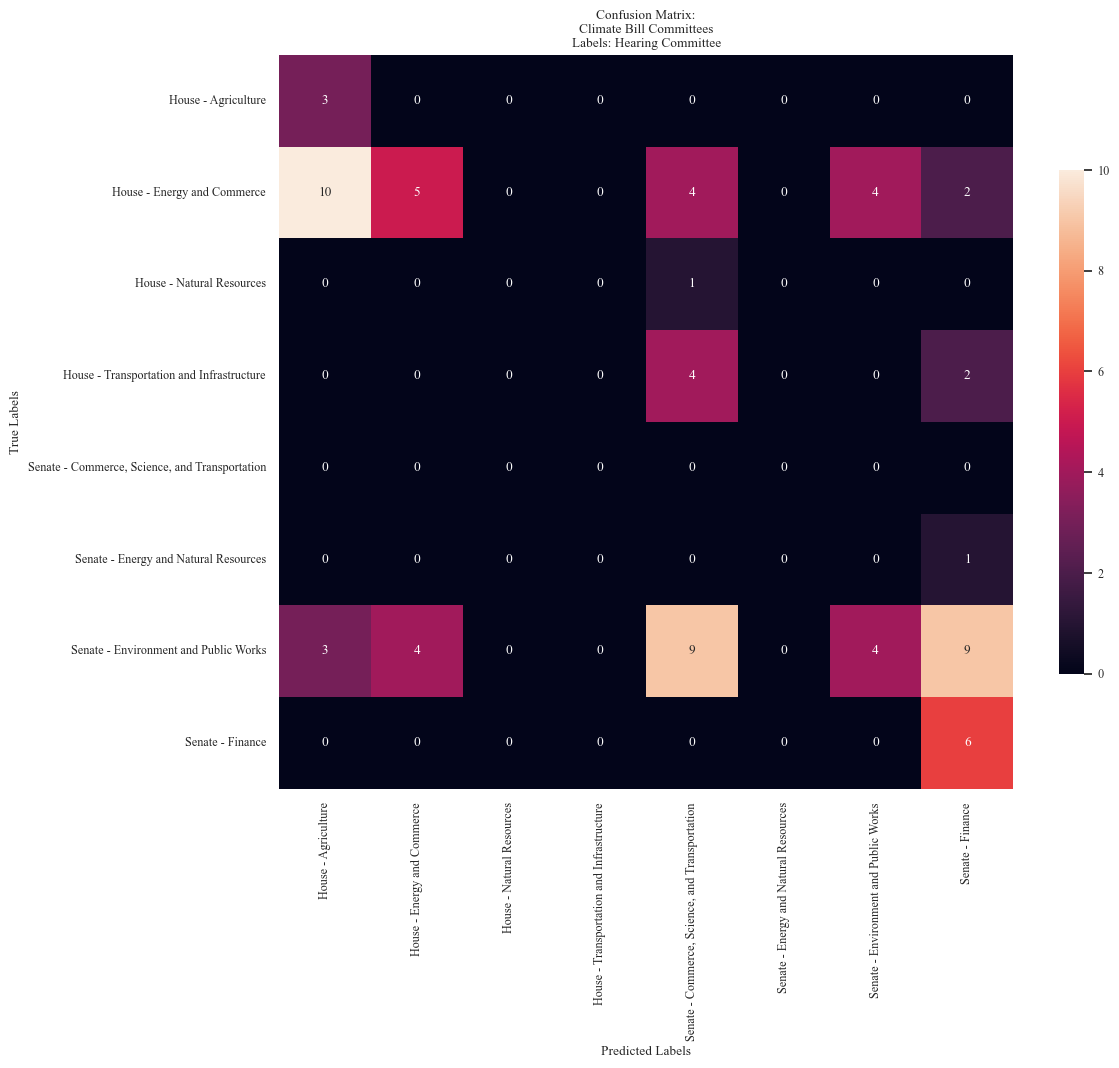

In [88]:
accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee = tree_modeler(data_train_bills_committee, labels_train_bills_committee,
                                                                                         data_test_bills_committee, labels_test_bills_committee,
                                                                                          'Committees',
                                                                                         'Climate Bill Committees',
                                                                                         'Climate Bill Committees', 'Hearing Committee', 'decision tree entropy cm- bill committee label.png',
                                                                                         True, 10 ,fig_x = 12, fig_y = 12)

## 4. Assessing Validity

### 4.1 Gini

In [74]:
data = [['News Headlines: Partisian Affiliation',accuracy_news_data_party, precision_news_data_party, recall_news_data_party],
['News Headlines: Publisher',accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher],
['News Headlines: Publisher and Partisian Affiliation',accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined],
['Climate Bills: Sponsor Affiliation',accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party],
['Climate Bills: Sponsor State',accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state],
['Climate Bills: Metadata',accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined],
['Climate Bills: Bill Type',accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type],
['Climate Bills: Hearing Committee',accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee]]


for row in data:
    for i in range(1, 4):  # Loop over the columns with numeric data (index 1, 2, 3)
        row[i] = round(row[i], 3)
        
headers = ['', ' Accuracy', 'Precision', 'Recall']

table = tabulate(data, headers=headers, tablefmt='html', numalign='center', stralign = 'left')

with open("Decision Tree Gini - Model Evaluation.html", "w") as file:
    file.write(table)

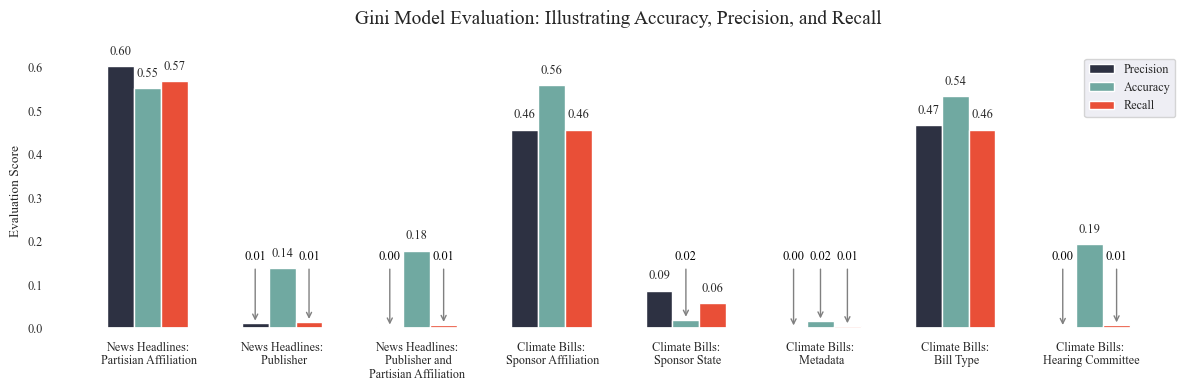

In [82]:
data = [['News Headlines:\n Partisian Affiliation',accuracy_news_data_party, precision_news_data_party, recall_news_data_party],
['News Headlines:\n Publisher',accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher],
['News Headlines:\n Publisher and\nPartisian Affiliation',accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined],
['Climate Bills:\n Sponsor Affiliation',accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party],
['Climate Bills:\n Sponsor State',accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state],
['Climate Bills:\n Metadata',accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined],
['Climate Bills:\n Bill Type',accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type],
['Climate Bills:\n Hearing Committee',accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee]]


for row in data:
    for i in range(1, 4):  # Loop over the columns with numeric data (index 1, 2, 3)
        row[i] = round(row[i], 3)

model_eval = pd.DataFrame(data, columns=['Model','Accuracy','Precision','Recall'])



fig, ax = plt.subplots(figsize=(12,4))
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=0.8)
ax.set_facecolor('white')

models = model_eval['Model'].to_list()
precision = model_eval['Precision'].to_list()
accuracy = model_eval['Accuracy'].to_list()
recall = model_eval['Recall'].to_list()



ax.set_facecolor('white')

# Width of the bars
bar_width = 0.2


index = np.arange(len(models))

# Plotting bars for Precision, Accuracy, and Recall
bar_precision = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='#2d3142')
bar_accuracy = ax.bar(index, accuracy, bar_width, label='Accuracy', color='#70a9a1')
bar_recall = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='#e94f37')

# Label each bar (with conditional floating & arrow)
def annotate_bars(bars):
    for bar in bars:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        if y < 0.05:
            ax.annotate(
                f'{y:.2f}',
                xy=(x, y),
                xytext=(x, 0.15),
                textcoords='data',
                ha='center', va='bottom',
                arrowprops=dict(arrowstyle='->', color='gray'),
                fontsize=9,
                color='black'
            )
        else:
            ax.text(x, y + 0.02, f'{y:.2f}', ha='center', va='bottom', fontsize=9)

# Apply annotation
annotate_bars(bar_precision)
annotate_bars(bar_accuracy)
annotate_bars(bar_recall)

ax.set_title("Gini Model Evaluation: Illustrating Accuracy, Precision, and Recall\n", fontsize=14)
ax.set_xlabel("")  
ax.set_ylabel("Evaluation Score")
ax.tick_params(axis='x')


ax.set_xticks(index)
ax.set_xticklabels(models)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Minor gridlines style
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Major gridlines style


ax.legend()

plt.tight_layout()

plt.savefig("Decision Trees Gini - Model Evaluation.png",dpi=1000)
plt.show();

### 4.2 Entropy

In [105]:
data = [['News Headlines: Partisian Affiliation',accuracy_news_data_party, precision_news_data_party, recall_news_data_party],
['News Headlines: Publisher',accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher],
['News Headlines: Publisher and Partisian Affiliation',accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined],
['Climate Bills: Sponsor Affiliation',accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party],
['Climate Bills: Sponsor State',accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state],
['Climate Bills: Metadata',accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined],
['Climate Bills: Bill Type',accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type],
['Climate Bills: Hearing Committee',accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee]]


for row in data:
    for i in range(1, 4):  # Loop over the columns with numeric data (index 1, 2, 3)
        row[i] = round(row[i], 3)
        
headers = ['', ' Accuracy', 'Precision', 'Recall']

table = tabulate(data, headers=headers, tablefmt='html', numalign='center', stralign = 'left')

with open("Decision Tree Entropy - Model Evaluation.html", "w") as file:
    file.write(table)

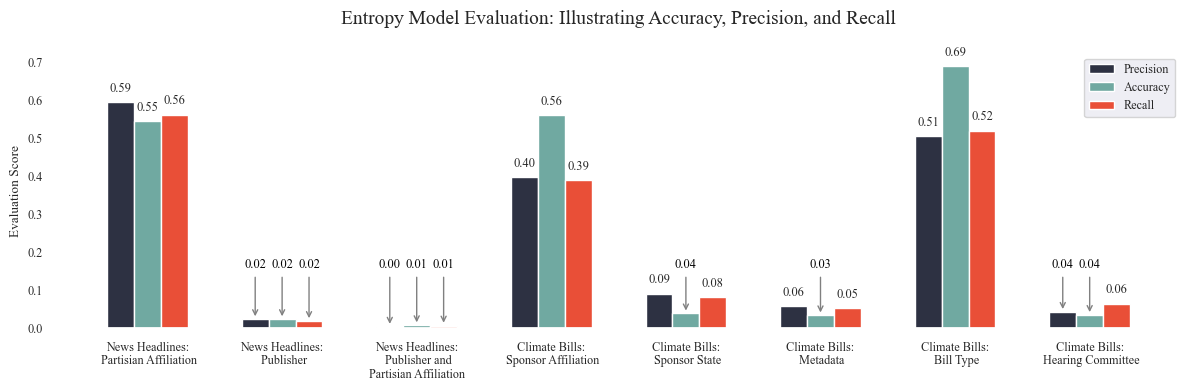

In [106]:
data = [['News Headlines:\n Partisian Affiliation',accuracy_news_data_party, precision_news_data_party, recall_news_data_party],
['News Headlines:\n Publisher',accuracy_news_data_publisher, precision_news_data_publisher, recall_news_data_publisher],
['News Headlines:\n Publisher and\nPartisian Affiliation',accuracy_news_data_combined, precision_news_data_combined, recall_news_data_combined],
['Climate Bills:\n Sponsor Affiliation',accuracy_bills_data_party, precision_bills_data_party, recall_bills_data_party],
['Climate Bills:\n Sponsor State',accuracy_bills_data_state, precision_bills_data_state, recall_bills_data_state],
['Climate Bills:\n Metadata',accuracy_bills_data_combined, precision_bills_data_combined, recall_bills_data_combined],
['Climate Bills:\n Bill Type',accuracy_bills_data_type, precision_bills_data_type, recall_bills_data_type],
['Climate Bills:\n Hearing Committee',accuracy_bills_data_committee, precision_bills_data_committee, recall_bills_data_committee]]


for row in data:
    for i in range(1, 4):  # Loop over the columns with numeric data (index 1, 2, 3)
        row[i] = round(row[i], 3)

model_eval = pd.DataFrame(data, columns=['Model','Accuracy','Precision','Recall'])



fig, ax = plt.subplots(figsize=(12,4))
sb.set_style("white")
sb.set(font='Times New Roman', font_scale=0.8)
ax.set_facecolor('white')

models = model_eval['Model'].to_list()
precision = model_eval['Precision'].to_list()
accuracy = model_eval['Accuracy'].to_list()
recall = model_eval['Recall'].to_list()



ax.set_facecolor('white')

# Width of the bars
bar_width = 0.2


index = np.arange(len(models))

# Plotting bars for Precision, Accuracy, and Recall
bar_precision = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='#2d3142')
bar_accuracy = ax.bar(index, accuracy, bar_width, label='Accuracy', color='#70a9a1')
bar_recall = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='#e94f37')

# Label each bar (with conditional floating & arrow)
def annotate_bars(bars):
    for bar in bars:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        if y < 0.05:
            ax.annotate(
                f'{y:.2f}',
                xy=(x, y),
                xytext=(x, 0.15),
                textcoords='data',
                ha='center', va='bottom',
                arrowprops=dict(arrowstyle='->', color='gray'),
                fontsize=9,
                color='black'
            )
        else:
            ax.text(x, y + 0.02, f'{y:.2f}', ha='center', va='bottom', fontsize=9)

# Apply annotation
annotate_bars(bar_precision)
annotate_bars(bar_accuracy)
annotate_bars(bar_recall)

ax.set_title("Entropy Model Evaluation: Illustrating Accuracy, Precision, and Recall\n", fontsize=14)
ax.set_xlabel("")  
ax.set_ylabel("Evaluation Score")
ax.tick_params(axis='x')


ax.set_xticks(index)
ax.set_xticklabels(models)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(which='minor', linestyle=':', linewidth='0.5')  # Minor gridlines style
ax.grid(which='major', linestyle='-', linewidth='0.75')  # Major gridlines style


ax.legend()

plt.tight_layout()

plt.savefig("Decision Trees Entropy - Model Evaluation.png",dpi=1000)
plt.show();